# Extract

## Extracting all tables shown in below diagram from s3 bucket using athena query

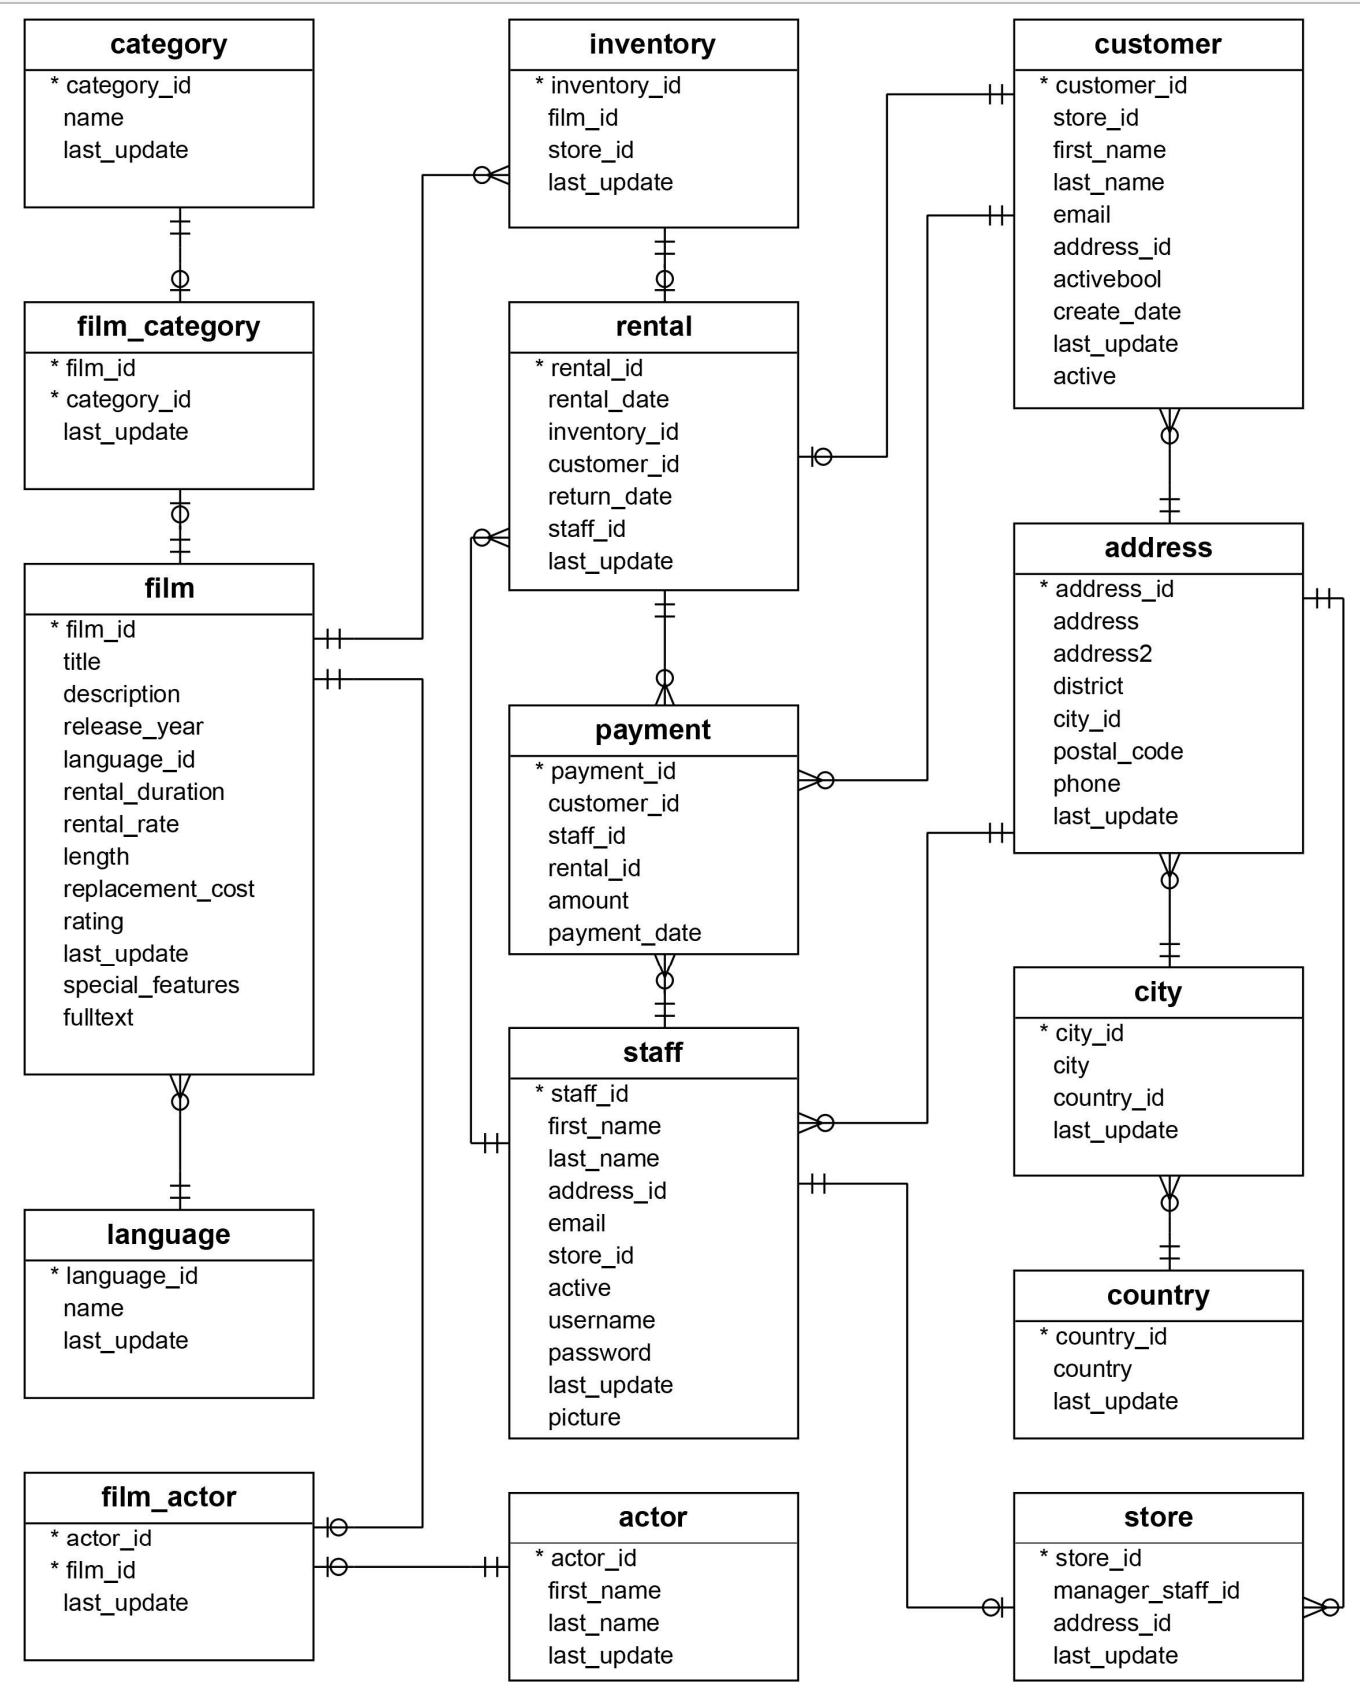

In [1]:
#!pip install boto3
#!pip install redshift-connector

In [2]:
import boto3 # for connecting with aws services
import time
import pandas as pd
import numpy as np
from io import StringIO # for creating file-like object

In [ ]:
AWS_ACCESS_KEY = str(input('Enter your aws access key: '))
AWS_SECRET_KEY = str(input('Enter your aws secret key: '))
AWS_REGION = "us-east-1"
SCHEMA_NAME = "dvdrental"
S3_STAGING_DIR = "s3://psp-dvdrental/output"
S3_BUCKET_NAME = "psp-dvdrental"
S3_OUTPUT_DIRECTORY = "output"

In [4]:
# connecting to athena
athena_client = boto3.client("athena",
                             aws_access_key_id=AWS_ACCESS_KEY,
                             aws_secret_access_key=AWS_SECRET_KEY,
                             region_name=AWS_REGION)

### Creating a function to download and load athena query results

In [5]:
Dict = {}
def download_and_load_query_results(
    client: boto3.client, query_response: Dict) -> pd.DataFrame:
    while True:
        try:
            client.get_query_results(
                QueryExecutionId=query_response['QueryExecutionId'])
            break
        except Exception as err:
            if "not yet finished" in str(err):
                time.sleep(0.001)
            else:
                raise err
    temp_file_location: str = "athena_query_results.csv"
    # connecting to s3
    s3_client = boto3.client("s3",
                             aws_access_key_id=AWS_ACCESS_KEY,
                             aws_secret_access_key=AWS_SECRET_KEY,
                             region_name=AWS_REGION)
    s3_client.download_file(S3_BUCKET_NAME,
                            f"{S3_OUTPUT_DIRECTORY}/{query_response['QueryExecutionId']}.csv",
                            temp_file_location)
    return pd.read_csv(temp_file_location)

### Creating a function to query and get all data from each table in s3 bucket

In [6]:
def query_table(table_name):
    response = athena_client.start_query_execution(
        QueryString=f"SELECT * FROM {table_name}",
        QueryExecutionContext={"Database": SCHEMA_NAME},
        ResultConfiguration={"OutputLocation": S3_STAGING_DIR,
                             "EncryptionConfiguration":{"EncryptionOption": "SSE_S3"}})
    return response

### Extracting each table into a dataframe and checking if all data are successfully extracted or not

In [7]:
actor = download_and_load_query_results(athena_client, query_table("actor"))
# actor table should have 200 rows and 4 columns for successful extraction of data
print('actor: ',actor.shape)
actor.head()

actor:  (200, 4)


,actor_id,first_name,last_name,last_update
0,1,Penelope,Guiness,2013-05-26 14:47:57.62
1,2,Nick,Wahlberg,2013-05-26 14:47:57.62
2,3,Ed,Chase,2013-05-26 14:47:57.62
3,4,Jennifer,Davis,2013-05-26 14:47:57.62
4,5,Johnny,Lollobrigida,2013-05-26 14:47:57.62


In [8]:
film = download_and_load_query_results(athena_client, query_table("film"))
# film table should have 1000 rows and 13 columns for successful extraction of data
print('film: ',film.shape)
film.head()

film:  (1000, 13)


,film_id,title,description,release_year,language_id,rental_duration,rental_rate,length,replacement_cost,rating,last_update,special_features,fulltext
0,133,Chamber Italian,A Fateful Reflection of a Moose And a Husband ...,2006,1,7,4.99,117,14.99,NC-17,2013-05-26 14:50:58.951,{Trailers},'chamber':1 'fate':4 'husband':11 'italian':2 ...
1,384,Grosse Wonderful,A Epic Drama of a Cat And a Explorer who must ...,2006,1,5,4.99,49,19.99,R,2013-05-26 14:50:58.951,"""{""""Behind the Scenes""""}""",'australia':18 'cat':8 'drama':5 'epic':4 'exp...
2,8,Airport Pollock,A Epic Tale of a Moose And a Girl who must Con...,2006,1,6,4.99,54,15.99,R,2013-05-26 14:50:58.951,{Trailers},'airport':1 'ancient':18 'confront':14 'epic':...
3,98,Bright Encounters,A Fateful Yarn of a Lumberjack And a Feminist ...,2006,1,4,4.99,73,12.99,PG-13,2013-05-26 14:50:58.951,{Trailers},'boat':20 'bright':1 'conquer':14 'encount':2 ...
4,1,Academy Dinosaur,A Epic Drama of a Feminist And a Mad Scientist...,2006,1,6,0.99,86,20.99,PG,2013-05-26 14:50:58.951,"""{""""Deleted Scenes""""","""""Behind the Scenes""""}"""


In [9]:
film_actor = download_and_load_query_results(athena_client, query_table("film_actor"))
# film_actor table should have 5462 rows and 3 columns for successful extraction of data
print('film_actor: ',film_actor.shape)
film_actor.head()

film_actor:  (5462, 3)


,actor_id,film_id,last_update
0,1,1,2006-02-15 10:05:03
1,1,23,2006-02-15 10:05:03
2,1,25,2006-02-15 10:05:03
3,1,106,2006-02-15 10:05:03
4,1,140,2006-02-15 10:05:03


In [10]:
category = download_and_load_query_results(athena_client, query_table("category"))
# category table should have 16 rows and 3 columns for successful extraction of data
print('category: ',category.shape)
category.head()

category:  (16, 3)


,category_id,name,last_update
0,1,Action,2006-02-15 09:46:27
1,2,Animation,2006-02-15 09:46:27
2,3,Children,2006-02-15 09:46:27
3,4,Classics,2006-02-15 09:46:27
4,5,Comedy,2006-02-15 09:46:27


In [11]:
film_category = download_and_load_query_results(athena_client, query_table("film_category"))
# film_category table should have 1000 rows and 3 columns for successful extraction of data
print('film_category: ',film_category.shape)
film_category.head()

film_category:  (1000, 3)


,film_id,category_id,last_update
0,1,6,2006-02-15 10:07:09
1,2,11,2006-02-15 10:07:09
2,3,6,2006-02-15 10:07:09
3,4,11,2006-02-15 10:07:09
4,5,8,2006-02-15 10:07:09


In [12]:
store = download_and_load_query_results(athena_client, query_table("store"))
# store table should have 2 rows and 4 columns for successful extraction of data
print('store: ',store.shape)
store.head()

store:  (2, 4)


,store_id,manager_staff_id,address_id,last_update
0,1,1,1,2006-02-15 09:57:12
1,2,2,2,2006-02-15 09:57:12


In [13]:
inventory = download_and_load_query_results(athena_client, query_table("inventory"))
# inventory table should have 4581 rows and 4 columns for successful extraction of data
print('inventory: ',inventory.shape)
inventory.head()

inventory:  (4581, 4)


,inventory_id,film_id,store_id,last_update
0,1,1,1,2006-02-15 10:09:17
1,2,1,1,2006-02-15 10:09:17
2,3,1,1,2006-02-15 10:09:17
3,4,1,1,2006-02-15 10:09:17
4,5,1,2,2006-02-15 10:09:17


In [14]:
rental = download_and_load_query_results(athena_client, query_table("rental"))
# rental table should have 16044 rows and 7 columns for successful extraction of data
print('rental: ',rental.shape)
rental.head()

rental:  (16044, 7)


,rental_id,rental_date,inventory_id,customer_id,return_date,staff_id,last_update
0,2,2005-05-24 22:54:33,1525,459,2005-05-28 19:40:33,1,2006-02-16 02:30:53
1,3,2005-05-24 23:03:39,1711,408,2005-06-01 22:12:39,1,2006-02-16 02:30:53
2,4,2005-05-24 23:04:41,2452,333,2005-06-03 01:43:41,2,2006-02-16 02:30:53
3,5,2005-05-24 23:05:21,2079,222,2005-06-02 04:33:21,1,2006-02-16 02:30:53
4,6,2005-05-24 23:08:07,2792,549,2005-05-27 01:32:07,1,2006-02-16 02:30:53


In [15]:
payment = download_and_load_query_results(athena_client, query_table("payment"))
# payment table should have 14596 rows and 6 columns for successful extraction of data
print('payment: ',payment.shape)
payment.head()

payment:  (14596, 6)


,payment_id,customer_id,staff_id,rental_id,amount,payment_date
0,24402,179,2,10569,3.99,2007-03-01 11:46:49.996577
1,24403,179,1,11342,0.99,2007-03-02 15:40:01.996577
2,24404,179,2,13240,0.99,2007-03-19 14:50:40.996577
3,24405,179,1,13400,4.99,2007-03-19 20:40:10.996577
4,24406,179,2,13844,7.99,2007-03-20 12:58:52.996577


In [16]:
staff = download_and_load_query_results(athena_client, query_table("staff"))
# staff table should have 2 rows and 11 columns for successful extraction of data
print('staff: ',staff.shape)
staff.head()

staff:  (2, 11)


,staff_id,first_name,last_name,address_id,email,store_id,active,username,password,last_update,picture
0,1,Mike,Hillyer,3,Mike.Hillyer@sakilastaff.com,1,t,Mike,8cb2237d0679ca88db6464eac60da96345513964,2006-05-16 16:13:11.79328,\x89504e470d0a5a0a
1,2,Jon,Stephens,4,Jon.Stephens@sakilastaff.com,2,t,Jon,8cb2237d0679ca88db6464eac60da96345513964,2006-05-16 16:13:11.79328,NaN


In [17]:
customer = download_and_load_query_results(athena_client, query_table("customer"))
# customer table should have 599 rows and 10 columns for successful extraction of data
print('customer: ',customer.shape)
customer.head()

customer:  (599, 10)


,customer_id,store_id,first_name,last_name,email,address_id,activebool,create_date,last_update,active
0,524,1,Jared,Ely,jared.ely@sakilacustomer.org,530,t,2006-02-14,2013-05-26 14:49:45.738,1
1,1,1,Mary,Smith,mary.smith@sakilacustomer.org,5,t,2006-02-14,2013-05-26 14:49:45.738,1
2,2,1,Patricia,Johnson,patricia.johnson@sakilacustomer.org,6,t,2006-02-14,2013-05-26 14:49:45.738,1
3,3,1,Linda,Williams,linda.williams@sakilacustomer.org,7,t,2006-02-14,2013-05-26 14:49:45.738,1
4,4,2,Barbara,Jones,barbara.jones@sakilacustomer.org,8,t,2006-02-14,2013-05-26 14:49:45.738,1


In [18]:
address = download_and_load_query_results(athena_client, query_table("address"))
# address table should have 603 rows and 8 columns for successful extraction of data
print('address: ',address.shape)
address.head()

address:  (603, 8)


,address_id,address,address2,district,city_id,postal_code,phone,last_update
0,1,47 MySakila Drive,NaN,Alberta,300,NaN,NaN,2006-02-15 09:45:30
1,2,28 MySQL Boulevard,NaN,QLD,576,NaN,NaN,2006-02-15 09:45:30
2,3,23 Workhaven Lane,NaN,Alberta,300,NaN,1.403334e+10,2006-02-15 09:45:30
3,4,1411 Lillydale Drive,NaN,QLD,576,NaN,6.172236e+09,2006-02-15 09:45:30
4,5,1913 Hanoi Way,"""""",Nagasaki,463,35200.0,2.830338e+10,2006-02-15 09:45:30


In [19]:
city = download_and_load_query_results(athena_client, query_table("city"))
# city table should have 600 rows and 4 columns for successful extraction of data
print('city: ',city.shape)
city.head()

city:  (600, 4)


,city_id,city,country_id,last_update
0,1,A Corua (La Corua),87,2006-02-15 09:45:25
1,2,Abha,82,2006-02-15 09:45:25
2,3,Abu Dhabi,101,2006-02-15 09:45:25
3,4,Acua,60,2006-02-15 09:45:25
4,5,Adana,97,2006-02-15 09:45:25


In [20]:
country = download_and_load_query_results(athena_client, query_table("country"))
# country table should have 109 rows and 3 columns for successful extraction of data
print('country: ',country.shape)
country.head()

country:  (109, 3)


,country_id,country,last_update
0,1,Afghanistan,2006-02-15 09:44:00
1,2,Algeria,2006-02-15 09:44:00
2,3,American Samoa,2006-02-15 09:44:00
3,4,Angola,2006-02-15 09:44:00
4,5,Anguilla,2006-02-15 09:44:00


In [21]:
language = download_and_load_query_results(athena_client, query_table("language"))
# language table should have 6 rows and 3 columns for successful extraction of data
print('language: ',language.shape)
language.head()

language:  (6, 3)


,language_id,name,last_update
0,1,English,2006-02-15 10:02:19
1,2,Italian,2006-02-15 10:02:19
2,3,Japanese,2006-02-15 10:02:19
3,4,Mandarin,2006-02-15 10:02:19
4,5,French,2006-02-15 10:02:19


# Transform

## Transform the extracted tables into the tables schema shown below

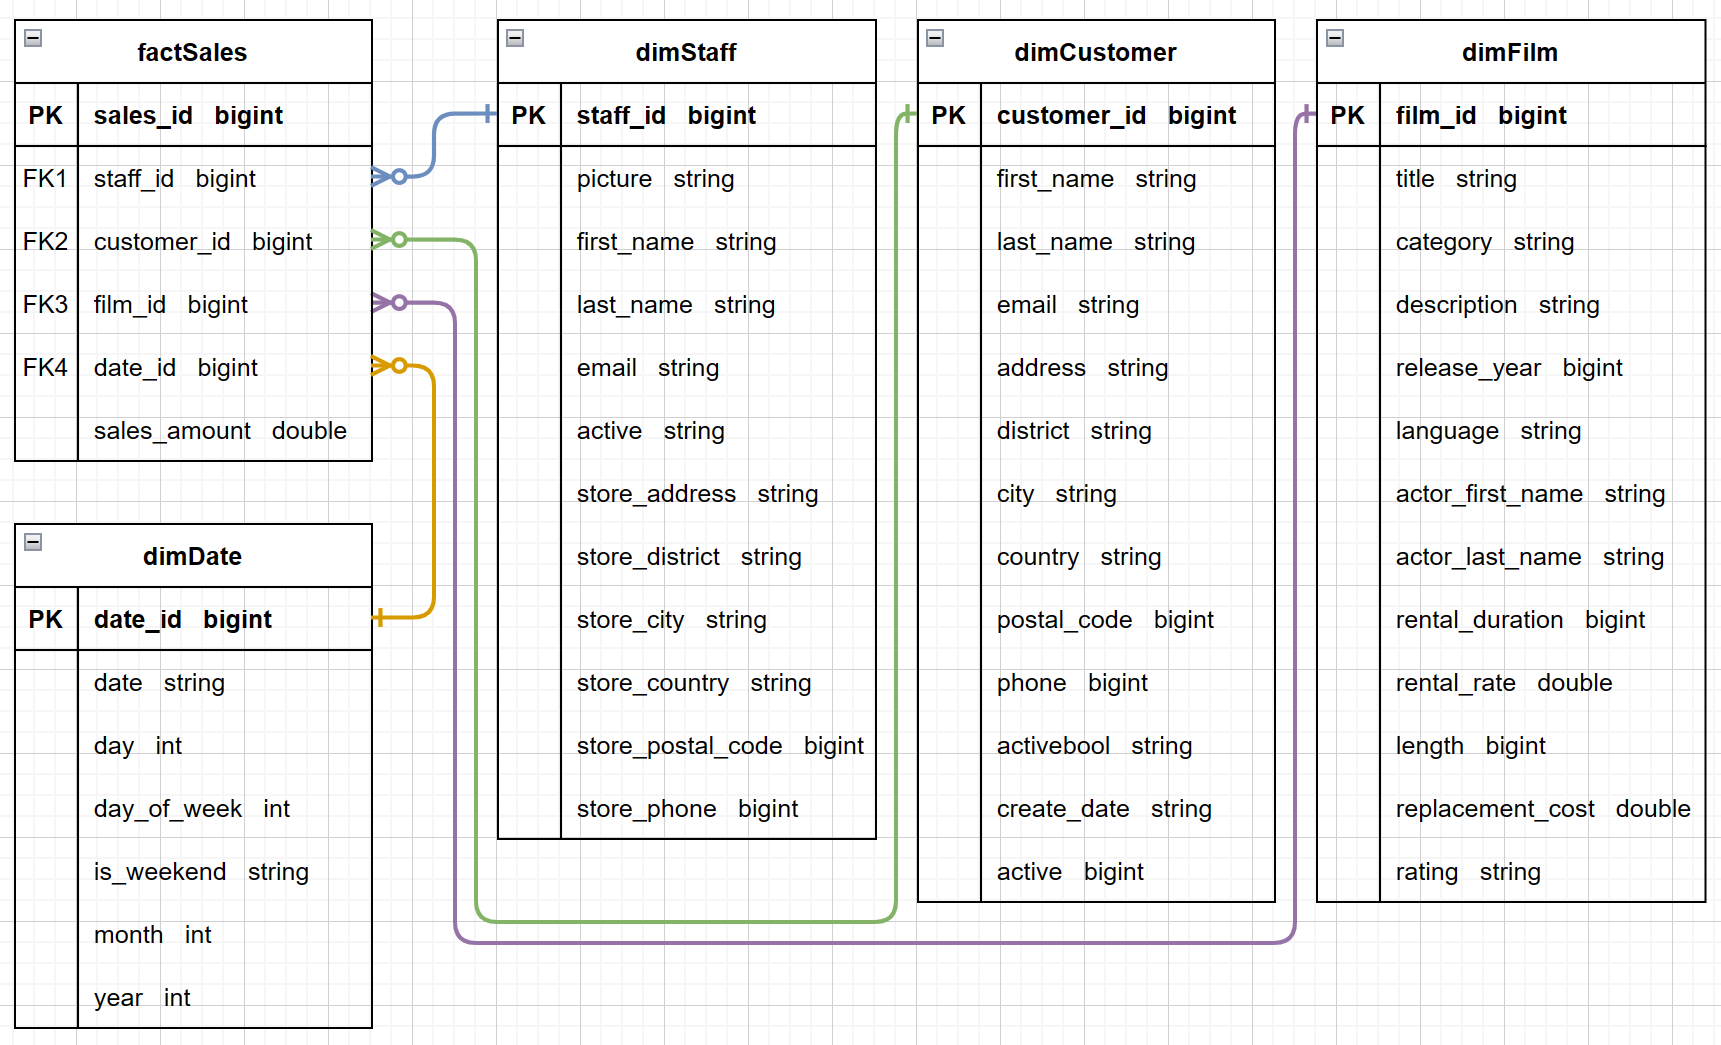

## Creating a dimension table, dimFilm table

### Merging category table and film_category table into dim_film_category_category table

In [22]:
# getting only the require columns from category table
dim_category = category[['category_id','name']]
# change column name 'name' to 'category'
dim_category.rename(columns={'name':'category'}, inplace=True)

dim_film_category = film_category[['film_id','category_id']]

dim_film_category_category = pd.merge(
    dim_film_category,dim_category, on='category_id', how='inner')
dim_film_category_category.head(2)

C:\Users\steve\anaconda3\lib\site-packages\pandas\core\frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


,film_id,category_id,category
0,1,6,Documentary
1,3,6,Documentary


### Merging actor table and film_actor table into dim_film_actor_actor table

In [23]:
dim_film_actor = film_actor[['actor_id','film_id']]

dim_actor = actor[['actor_id','first_name','last_name']]
# change colum names
dim_actor.rename(columns={'first_name':'actor_first_name',
                          'last_name':'actor_last_name'}, inplace=True)

dim_film_actor_actor = pd.merge(dim_film_actor, dim_actor, on='actor_id', how='inner')
dim_film_actor_actor.head(2)

C:\Users\steve\anaconda3\lib\site-packages\pandas\core\frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


,actor_id,film_id,actor_first_name,actor_last_name
0,1,1,Penelope,Guiness
1,1,23,Penelope,Guiness


### Merging film table and language table into dimFilm table

In [24]:
dim_film = film[['film_id','title','description','release_year','language_id',
                  'rental_duration','rental_rate','length',
                  'replacement_cost','rating']]

dim_language = language [['language_id','name']]
# change column names
dim_language.rename(columns={'name':'language'}, inplace=True)

dimFilm = pd.merge(dim_film, dim_language, on='language_id', how='inner')
dimFilm.head(2)

C:\Users\steve\anaconda3\lib\site-packages\pandas\core\frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


,film_id,title,description,release_year,language_id,rental_duration,rental_rate,length,replacement_cost,rating,language
0,133,Chamber Italian,A Fateful Reflection of a Moose And a Husband ...,2006,1,7,4.99,117,14.99,NC-17,English
1,384,Grosse Wonderful,A Epic Drama of a Cat And a Explorer who must ...,2006,1,5,4.99,49,19.99,R,English


### Merging everything (dim_film_category_category, dim_film_actor_actor) into dimFilm table

In [25]:
dimFilm = pd.merge(dimFilm, dim_film_category_category, on='film_id', how='inner')
dimFilm = pd.merge(dimFilm, dim_film_actor_actor, on='film_id', how='inner')
dimFilm.head(2)

,film_id,title,description,release_year,language_id,rental_duration,rental_rate,length,replacement_cost,rating,language,category_id,category,actor_id,actor_first_name,actor_last_name
0,133,Chamber Italian,A Fateful Reflection of a Moose And a Husband ...,2006,1,7,4.99,117,14.99,NC-17,English,12,Music,29,Alec,Wayne
1,133,Chamber Italian,A Fateful Reflection of a Moose And a Husband ...,2006,1,7,4.99,117,14.99,NC-17,English,12,Music,60,Henry,Berry


### Removing unnecessary columns from dimFilm table

In [26]:
#category,language,actor id remove
dimFilm.drop(['category_id','actor_id','language_id'], axis=1, inplace=True)
dimFilm.head(2)

,film_id,title,description,release_year,rental_duration,rental_rate,length,replacement_cost,rating,language,category,actor_first_name,actor_last_name
0,133,Chamber Italian,A Fateful Reflection of a Moose And a Husband ...,2006,7,4.99,117,14.99,NC-17,English,Music,Alec,Wayne
1,133,Chamber Italian,A Fateful Reflection of a Moose And a Husband ...,2006,7,4.99,117,14.99,NC-17,English,Music,Henry,Berry


In [27]:
# rearrange columns
dimFilm = dimFilm[['film_id','title','category','description','release_year',
                   'language','actor_first_name','actor_last_name','rental_duration',
                   'rental_rate','length','replacement_cost','rating']]
dimFilm.head()

,film_id,title,category,description,release_year,language,actor_first_name,actor_last_name,rental_duration,rental_rate,length,replacement_cost,rating
0,133,Chamber Italian,Music,A Fateful Reflection of a Moose And a Husband ...,2006,English,Alec,Wayne,7,4.99,117,14.99,NC-17
1,133,Chamber Italian,Music,A Fateful Reflection of a Moose And a Husband ...,2006,English,Henry,Berry,7,4.99,117,14.99,NC-17
2,133,Chamber Italian,Music,A Fateful Reflection of a Moose And a Husband ...,2006,English,Rip,Winslet,7,4.99,117,14.99,NC-17
3,133,Chamber Italian,Music,A Fateful Reflection of a Moose And a Husband ...,2006,English,Gina,Degeneres,7,4.99,117,14.99,NC-17
4,133,Chamber Italian,Music,A Fateful Reflection of a Moose And a Husband ...,2006,English,Adam,Hopper,7,4.99,117,14.99,NC-17


## Creating a dimension table, dimCustomer table

### Merging city table and country table into dim_city_country table

In [28]:
dim_city = city[['city_id','city','country_id']]
dim_country = country[['country_id','country']]
dim_city_country = pd.merge(dim_city,dim_country, on='country_id', how='inner')
dim_city_country.head(2)

,city_id,city,country_id,country
0,1,A Corua (La Corua),87,Spain
1,146,Donostia-San Sebastin,87,Spain


### Merging address table and dim_city_country table into dim_address_city_country table

In [29]:
dim_address = address[['address_id','address','district','city_id','postal_code','phone']]
dim_address_city_country = pd.merge(dim_address, dim_city_country, on='city_id', how='inner')
dim_address_city_country.head(2)

,address_id,address,district,city_id,postal_code,phone,city,country_id,country
0,1,47 MySakila Drive,Alberta,300,NaN,NaN,Lethbridge,20,Canada
1,3,23 Workhaven Lane,Alberta,300,NaN,1.403334e+10,Lethbridge,20,Canada


### Merging customer table and dim_address_city_country table into dimCustomer table

In [30]:
dim_customer = customer[['customer_id','first_name','last_name','email',
                         'address_id','activebool','create_date','active']]
dimCustomer = pd.merge(
    dim_customer, dim_address_city_country, on='address_id', how='inner')
dimCustomer.head(2)

,customer_id,first_name,last_name,email,address_id,activebool,create_date,active,address,district,city_id,postal_code,phone,city,country_id,country
0,524,Jared,Ely,jared.ely@sakilacustomer.org,530,t,2006-02-14,1,1003 Qinhuangdao Street,West Java,419,25972.0,3.553312e+10,Purwakarta,45,Indonesia
1,1,Mary,Smith,mary.smith@sakilacustomer.org,5,t,2006-02-14,1,1913 Hanoi Way,Nagasaki,463,35200.0,2.830338e+10,Sasebo,50,Japan


### Removing unnecessary columns from dimCustomer table

In [31]:
dimCustomer.drop(['address_id','city_id','country_id'], axis=1, inplace=True)
dimCustomer.head(2)

,customer_id,first_name,last_name,email,activebool,create_date,active,address,district,postal_code,phone,city,country
0,524,Jared,Ely,jared.ely@sakilacustomer.org,t,2006-02-14,1,1003 Qinhuangdao Street,West Java,25972.0,3.553312e+10,Purwakarta,Indonesia
1,1,Mary,Smith,mary.smith@sakilacustomer.org,t,2006-02-14,1,1913 Hanoi Way,Nagasaki,35200.0,2.830338e+10,Sasebo,Japan


In [32]:
# rearrange columns
dimCustomer = dimCustomer[['customer_id','first_name','last_name','email','address',
                           'district','city','country','postal_code','phone',
                           'activebool','create_date','active']]
dimCustomer.head()

,customer_id,first_name,last_name,email,address,district,city,country,postal_code,phone,activebool,create_date,active
0,524,Jared,Ely,jared.ely@sakilacustomer.org,1003 Qinhuangdao Street,West Java,Purwakarta,Indonesia,25972.0,3.553312e+10,t,2006-02-14,1
1,1,Mary,Smith,mary.smith@sakilacustomer.org,1913 Hanoi Way,Nagasaki,Sasebo,Japan,35200.0,2.830338e+10,t,2006-02-14,1
2,2,Patricia,Johnson,patricia.johnson@sakilacustomer.org,1121 Loja Avenue,California,San Bernardino,United States,17886.0,8.386353e+11,t,2006-02-14,1
3,3,Linda,Williams,linda.williams@sakilacustomer.org,692 Joliet Street,Attika,Athenai,Greece,83579.0,4.484772e+11,t,2006-02-14,1
4,4,Barbara,Jones,barbara.jones@sakilacustomer.org,1566 Inegl Manor,Mandalay,Myingyan,Myanmar,53561.0,7.058140e+11,t,2006-02-14,1


## Creating a dimension table, dimStaff table

### Merging store table and dim_address_city_country table into dim_store_address table

In [33]:
dim_store = store[['store_id','address_id']]
dim_store_address = pd.merge(
    dim_store, dim_address_city_country, on='address_id', how='inner')
# change columns name
dim_store_address.rename(columns={
    'address':'store_address','district':'store_district','city':'store_city',
    'country':'store_country','postal_code':'store_postal_code','phone':'store_phone'},
                         inplace=True)
dim_store_address.head(2)

,store_id,address_id,store_address,store_district,city_id,store_postal_code,store_phone,store_city,country_id,store_country
0,1,1,47 MySakila Drive,Alberta,300,NaN,NaN,Lethbridge,20,Canada
1,2,2,28 MySQL Boulevard,QLD,576,NaN,NaN,Woodridge,8,Australia


### Merging staff table and dim_store_address table into dimStaff table

In [34]:
dim_staff = staff[['staff_id','first_name','last_name','email',
                   'store_id','active','picture']]
dimStaff = pd.merge(dim_staff, dim_store_address, on='store_id', how='inner')
dimStaff.head(2)

,staff_id,first_name,last_name,email,store_id,active,picture,address_id,store_address,store_district,city_id,store_postal_code,store_phone,store_city,country_id,store_country
0,1,Mike,Hillyer,Mike.Hillyer@sakilastaff.com,1,t,\x89504e470d0a5a0a,1,47 MySakila Drive,Alberta,300,NaN,NaN,Lethbridge,20,Canada
1,2,Jon,Stephens,Jon.Stephens@sakilastaff.com,2,t,NaN,2,28 MySQL Boulevard,QLD,576,NaN,NaN,Woodridge,8,Australia


### Removing unnecessary columns from dimStaff table

In [35]:
dimStaff.drop(['store_id','address_id','city_id','country_id'], axis=1, inplace=True)
dimStaff.head(2)

,staff_id,first_name,last_name,email,active,picture,store_address,store_district,store_postal_code,store_phone,store_city,store_country
0,1,Mike,Hillyer,Mike.Hillyer@sakilastaff.com,t,\x89504e470d0a5a0a,47 MySakila Drive,Alberta,NaN,NaN,Lethbridge,Canada
1,2,Jon,Stephens,Jon.Stephens@sakilastaff.com,t,NaN,28 MySQL Boulevard,QLD,NaN,NaN,Woodridge,Australia


In [36]:
# rearrange columns
dimStaff = dimStaff[['staff_id','picture','first_name','last_name','email',
                     'active','store_address','store_district','store_city',
                     'store_country','store_postal_code','store_phone']]
dimStaff.head()

,staff_id,picture,first_name,last_name,email,active,store_address,store_district,store_city,store_country,store_postal_code,store_phone
0,1,\x89504e470d0a5a0a,Mike,Hillyer,Mike.Hillyer@sakilastaff.com,t,47 MySakila Drive,Alberta,Lethbridge,Canada,NaN,NaN
1,2,NaN,Jon,Stephens,Jon.Stephens@sakilastaff.com,t,28 MySQL Boulevard,QLD,Woodridge,Australia,NaN,NaN


## Creating a dimension table, dimDate table

### Creating dimDate table from 'payment_date' column in payment table

In [37]:
dimDate = payment[['payment_date']]
# spliting date and time into separate columns
dimDate[['date','time']] = dimDate.payment_date.str.split(' ',expand=True)
# inserting a column to use as primary key
dimDate.insert(0,'date_id',range(1,1+len(dimDate)))
dimDate.head()

C:\Users\steve\anaconda3\lib\site-packages\pandas\core\frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,date_id,payment_date,date,time
0,1,2007-03-01 11:46:49.996577,2007-03-01,11:46:49.996577
1,2,2007-03-02 15:40:01.996577,2007-03-02,15:40:01.996577
2,3,2007-03-19 14:50:40.996577,2007-03-19,14:50:40.996577
3,4,2007-03-19 20:40:10.996577,2007-03-19,20:40:10.996577
4,5,2007-03-20 12:58:52.996577,2007-03-20,12:58:52.996577


### Creating a separate column of date, day, day_of_week, is_weekend, month, year in dimDate table

In [38]:
# converting 'date' column data type into datetime format
dimDate['date'] = pd.to_datetime(dimDate['date'])

dimDate['day'] = dimDate['date'].dt.day
dimDate['day_of_week'] = dimDate['date'].dt.dayofweek

# Saturday = 5 and Sunday = 6 in day_of_week column
dimDate['is_weekend'] = np.where(dimDate['day_of_week'] >= 5, True, False)
dimDate['is_weekend'] = dimDate['is_weekend'].astype('str')
dimDate['month'] = dimDate['date'].dt.month
dimDate['year'] = dimDate['date'].dt.year

dimDate.head()

C:\Users\steve\AppData\Local\Temp/ipykernel_8676/3088201448.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dimDate['date'] = pd.to_datetime(dimDate['date'])
C:\Users\steve\AppData\Local\Temp/ipykernel_8676/3088201448.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dimDate['day'] = dimDate['date'].dt.day


,date_id,payment_date,date,time,day,day_of_week,is_weekend,month,year
0,1,2007-03-01 11:46:49.996577,2007-03-01,11:46:49.996577,1,3,False,3,2007
1,2,2007-03-02 15:40:01.996577,2007-03-02,15:40:01.996577,2,4,False,3,2007
2,3,2007-03-19 14:50:40.996577,2007-03-19,14:50:40.996577,19,0,False,3,2007
3,4,2007-03-19 20:40:10.996577,2007-03-19,20:40:10.996577,19,0,False,3,2007
4,5,2007-03-20 12:58:52.996577,2007-03-20,12:58:52.996577,20,1,False,3,2007


### Removing unnecessary columns from dimDate table

In [39]:
# create fact_date table to be use in creating factSales table
fact_date = dimDate[['date_id','payment_date']]

# remove payment_date and time columns
dimDate.drop(['payment_date','time'], axis=1, inplace=True)
dimDate.head()

,date_id,date,day,day_of_week,is_weekend,month,year
0,1,2007-03-01,1,3,False,3,2007
1,2,2007-03-02,2,4,False,3,2007
2,3,2007-03-19,19,0,False,3,2007
3,4,2007-03-19,19,0,False,3,2007
4,5,2007-03-20,20,1,False,3,2007


In [40]:
# check fact_date table
fact_date.head()

,date_id,payment_date
0,1,2007-03-01 11:46:49.996577
1,2,2007-03-02 15:40:01.996577
2,3,2007-03-19 14:50:40.996577
3,4,2007-03-19 20:40:10.996577
4,5,2007-03-20 12:58:52.996577


## Creating a fact table, factSales table

### Merging inventory table and rental table into fact_rental_inventory table

In [41]:
fact_inventory = inventory[['inventory_id','film_id']]
fact_rental = rental[['rental_id','inventory_id']]
fact_rental_inventory = pd.merge(fact_rental, fact_inventory, on='inventory_id', how='inner')
fact_rental_inventory.head(2)

,rental_id,inventory_id,film_id
0,2,1525,333
1,1449,1525,333


### Merging payment table and fact_rental_inventory table into fact_payment table

In [42]:
fact_payment = pd.merge(payment, fact_rental_inventory, on='rental_id', how='inner')
# change columns name
fact_payment.rename(columns={'payment_id':'sales_id','amount':'sales_amount'}, inplace=True)
fact_payment.head(2)

,sales_id,customer_id,staff_id,rental_id,sales_amount,payment_date,inventory_id,film_id
0,24402,179,2,10569,3.99,2007-03-01 11:46:49.996577,611,132
1,24403,179,1,11342,0.99,2007-03-02 15:40:01.996577,4251,924


### Merging fact_payment table and fact_date table into factSales table

In [43]:
factSales = pd.merge(fact_payment, fact_date, on='payment_date', how='inner')
factSales.head(2)

,sales_id,customer_id,staff_id,rental_id,sales_amount,payment_date,inventory_id,film_id,date_id
0,24402,179,2,10569,3.99,2007-03-01 11:46:49.996577,611,132,1
1,24403,179,1,11342,0.99,2007-03-02 15:40:01.996577,4251,924,2


### Removing unnecessary columns from factSales table

In [44]:
factSales.drop(['rental_id','inventory_id','payment_date'], axis=1, inplace=True)
factSales.head(2)

,sales_id,customer_id,staff_id,sales_amount,film_id,date_id
0,24402,179,2,3.99,132,1
1,24403,179,1,0.99,924,2


In [45]:
# rearrange columns
factSales = factSales[['sales_id','staff_id','customer_id',
                      'film_id','date_id','sales_amount']]
factSales.head()

,sales_id,staff_id,customer_id,film_id,date_id,sales_amount
0,24402,2,179,132,1,3.99
1,24403,1,179,924,2,0.99
2,24404,2,179,309,3,0.99
3,24405,1,179,469,4,4.99
4,24406,2,179,219,5,7.99


# Load

## Saving the transformed tables into s3 bucket and load them into redshift data warehouse

### Saving transformed tables into s3 bucket

In [46]:
s3_resource = boto3.resource('s3',
                             aws_access_key_id=AWS_ACCESS_KEY,
                             aws_secret_access_key=AWS_SECRET_KEY,
                             region_name=AWS_REGION)

transformed_tables = {'dimFilm':dimFilm, 'dimCustomer':dimCustomer,
                      'dimStaff':dimStaff, 'dimDate':dimDate,
                      'factSales':factSales}
for table_name, table in transformed_tables.items():
    csv_buffer = StringIO()
    table.to_csv(csv_buffer, index=False)
    s3_resource.Object(S3_BUCKET_NAME,f"transformed_tables/{table_name}.csv").put(Body=csv_buffer.getvalue())

### Getting table schema of each tables for table creation in redshift

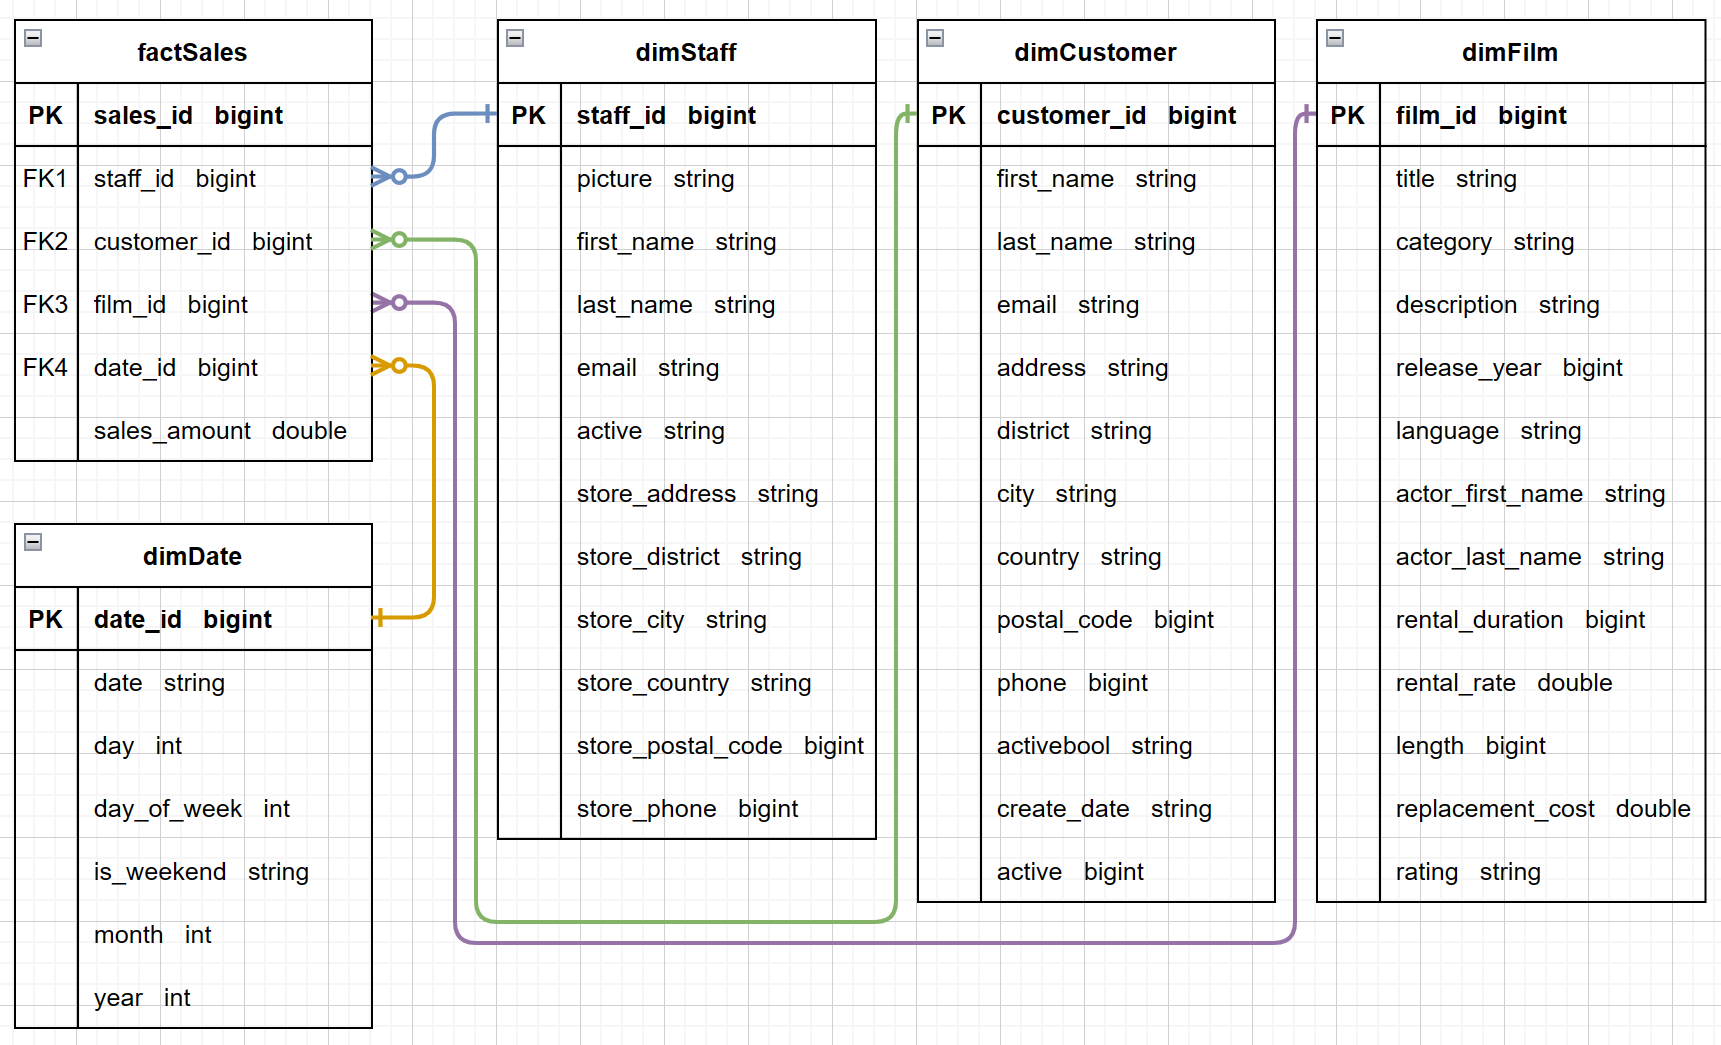

In [47]:
# dimFilm schema
dimFilm_schema = pd.io.sql.get_schema(dimFilm.reset_index(drop=True),'dimFilm')
create_dimFilm = ''.join(dimFilm_schema)
print(create_dimFilm)

CREATE TABLE "dimFilm" (
"film_id" INTEGER,
  "title" TEXT,
  "category" TEXT,
  "description" TEXT,
  "release_year" INTEGER,
  "language" TEXT,
  "actor_first_name" TEXT,
  "actor_last_name" TEXT,
  "rental_duration" INTEGER,
  "rental_rate" REAL,
  "length" INTEGER,
  "replacement_cost" REAL,
  "rating" TEXT
)


In [48]:
# dimCustomer schema
dimCustomer_schema = pd.io.sql.get_schema(dimCustomer.reset_index(drop=True),'dimCustomer')
create_dimCustomer = ''.join(dimCustomer_schema)
print(create_dimCustomer)

CREATE TABLE "dimCustomer" (
"customer_id" INTEGER,
  "first_name" TEXT,
  "last_name" TEXT,
  "email" TEXT,
  "address" TEXT,
  "district" TEXT,
  "city" TEXT,
  "country" TEXT,
  "postal_code" REAL,
  "phone" REAL,
  "activebool" TEXT,
  "create_date" TEXT,
  "active" INTEGER
)


In [49]:
# dimStaff schema
dimStaff_schema = pd.io.sql.get_schema(dimStaff.reset_index(drop=True),'dimStaff')
create_dimStaff = ''.join(dimStaff_schema)
print(create_dimStaff)

CREATE TABLE "dimStaff" (
"staff_id" INTEGER,
  "picture" TEXT,
  "first_name" TEXT,
  "last_name" TEXT,
  "email" TEXT,
  "active" TEXT,
  "store_address" TEXT,
  "store_district" TEXT,
  "store_city" TEXT,
  "store_country" TEXT,
  "store_postal_code" REAL,
  "store_phone" REAL
)


In [50]:
# dimDate schema
dimDate_schema = pd.io.sql.get_schema(dimDate.reset_index(drop=True),'dimDate')
create_dimDate = ''.join(dimDate_schema)
print(create_dimDate)

CREATE TABLE "dimDate" (
"date_id" INTEGER,
  "date" TIMESTAMP,
  "day" INTEGER,
  "day_of_week" INTEGER,
  "is_weekend" TEXT,
  "month" INTEGER,
  "year" INTEGER
)


In [51]:
# factSales schema
factSales_schema = pd.io.sql.get_schema(factSales.reset_index(drop=True),'factSales')
create_factSales = ''.join(factSales_schema)
print(create_factSales)

CREATE TABLE "factSales" (
"sales_id" INTEGER,
  "staff_id" INTEGER,
  "customer_id" INTEGER,
  "film_id" INTEGER,
  "date_id" INTEGER,
  "sales_amount" REAL
)


### Creating connection to redshift data warehouse

In [ ]:
import redshift_connector

redshift_user = str(input('Please Enter Your Redshift User Name: '))
redshift_pass = str(input('Please Enter Your Redshift Password: '))

conn = redshift_connector.connect(
    # endpoint of redshift cluster without port number and database name
    host='redshift-dvdrental.cmvn5zucztlv.us-east-1.redshift.amazonaws.com',
    database='dvdrental',
    user=redshift_user,
    password=redshift_pass)
conn.autocommit = True

cursor = redshift_connector.Cursor = conn.cursor()

### Creating tables in redshift data warehouse

In [53]:
create_tables = [create_dimFilm, create_dimCustomer,
                create_dimStaff, create_dimDate, create_factSales]

for table in create_tables:
    cursor.execute(f"""{table}""")

### Loading table data into tables created in redshift data warehouse

In [54]:
table_names = ['dimFilm','dimCustomer','dimStaff','dimDate','factSales']
for tablename in table_names:
    cursor.execute(f"""
    copy {tablename} from 's3://psp-dvdrental/transformed_tables/{tablename}.csv'
    delimiter ','
    credentials 'aws_iam_role=arn:aws:iam::276768453643:role/service-role/AmazonRedshift-CommandsAccessRole-20230126T181450'
    region 'us-east-1'
    IGNOREHEADER 1
    """)

In [55]:
conn.close()